In [4]:
library(forcats)
library(readxl)
library(ggplot2)
library(gridExtra)
library(dplyr)
library(leaps)
library(pROC)
library(stats)
library(bestglm)
library(glmnet)
library(ROCR)
library(FactoMineR) 
library(factoextra)
library(mclust)
library(labelled)
library(tidyverse)

In [3]:
insa <- read_excel("./survey.xlsx")
insa <- as.data.frame(insa)
insa <- insa[,1:53]
insa <- mutate_all(insa, as.factor)
str(insa)
head(insa)

New names:
• `Tiers_temps` -> `Tiers_temps...9`
• `Presence_CM` -> `Presence_CM...16`
• `Presence_TD` -> `Presence_TD...17`
• `Presence_TP` -> `Presence_TP...18`
• `Tiers_temps` -> `Tiers_temps...90`
• `Presence_CM` -> `Presence_CM...133`
• `Presence_TD` -> `Presence_TD...134`
• `Presence_TP` -> `Presence_TP...135`
• `` -> `...415`
• `` -> `...416`
• `` -> `...417`
• `` -> `...418`
• `` -> `...419`


'data.frame':	1185 obs. of  53 variables:
 $ id                   : Factor w/ 1185 levels "3","4","5","8",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ trajet               : Factor w/ 4 levels "+30min","0-5min",..: 3 4 2 4 4 4 3 3 2 2 ...
 $ logement             : Factor w/ 3 levels "colocation","foyer familial",..: 3 3 3 3 1 1 3 3 3 3 ...
 $ surf_logement        : Factor w/ 5 levels "- 10m2","+ 30m2",..: 2 2 3 2 5 5 4 2 3 4 ...
 $ sent_logement        : Factor w/ 4 levels "pas du tout",..: 4 4 3 4 4 4 4 4 3 3 ...
 $ act_pro              : Factor w/ 5 levels "aucune","oui +15h",..: 1 1 1 1 1 3 1 2 1 1 ...
 $ Bourse               : Factor w/ 4 levels "echelon  4-7",..: 3 4 4 4 4 4 4 4 2 4 ...
 $ handicap             : Factor w/ 2 levels "non","oui": 1 1 1 1 1 1 1 1 1 2 ...
 $ Tiers_temps...9      : Factor w/ 2 levels "Non","Oui": 1 1 1 1 2 1 1 1 1 2 ...
 $ Stress               : Factor w/ 4 levels "jamais","parfois",..: 3 3 3 4 3 4 4 3 3 3 ...
 $ travail_sem          : Factor w/ 5 levels "+4h","0-1h

,id,trajet,logement,surf_logement,sent_logement,act_pro,Bourse,handicap,Tiers_temps...9,Stress,⋯,Sensation_reussite,Adequation_projet_pro,Promo,Spe/PO,Cohorte,Bac_origine,Resultat_1A,Resultat_preced,Redoublement,Rattrapages
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,3,15-30min,seul,+ 30m2,tout à fait,aucune,echelon 1-3,non,Non,souvent,⋯,plutôt non,plutôt oui,4A,GMM,classique,Fr,pas de classement,25-50%,Non,aucun
2,4,5-15min,seul,+ 30m2,tout à fait,aucune,non,non,Non,souvent,⋯,tout à fait,tout à fait,4A,GMM,classique,Fr,0-10%,0-10%,Non,aucun
3,5,0-5min,seul,10-20m2,plutôt oui,aucune,non,non,Non,souvent,⋯,plutôt oui,plutôt oui,4A,GMM,classique,Fr,50-75%,25-50%,Non,aucun
4,8,5-15min,seul,+ 30m2,tout à fait,aucune,non,non,Non,toujours,⋯,plutôt oui,plutôt non,4A,GB,classique,Fr,25-50%,10-25%,Non,aucun
5,9,5-15min,colocation,coloc ou foyer familial,tout à fait,aucune,non,non,Oui,souvent,⋯,plutôt oui,tout à fait,4A,GB,classique,Fr,pas de classement,50-75%,Oui,1 par semestre
6,11,5-15min,colocation,coloc ou foyer familial,tout à fait,oui 1-5h,non,non,Non,toujours,⋯,plutôt non,plutôt oui,4A,GB,classique,Fr,50-75%,jsp,Oui,2/3 par semestre


In [3]:
insa <- filter(insa, Resultat_preced == "0-10%" | Resultat_preced == "10-25%" | Resultat_preced == "25-50%" | Resultat_preced == "50-75%" | Resultat_preced == "75-100%" | Resultat_preced == "redoubl" | Resultat_preced == "amenag")
insa <- filter(insa, Promo == "2A" | Promo == "3A" | Promo == "4A" | Promo == "5A")
insa <- insa[-c(531,576,601), ]
str(insa)
head(insa)
missing_data <- colMeans(is.na(insa)) * 100

# Trier les résultats par ordre décroissant
sorted_missing_data <- sort(missing_data, decreasing = TRUE)

# Afficher les résultats de manière propre
cat("Pourcentage de données manquantes par variable (ordre décroissant):\n")
for (i in seq_along(sorted_missing_data)) {
  cat(names(sorted_missing_data)[i], ": ", sprintf("%.2f", sorted_missing_data[i]), "%\n")
}

'data.frame':	744 obs. of  53 variables:
 $ id                   : Factor w/ 1185 levels "3","4","5","8",..: 1 2 3 4 5 8 9 10 11 12 ...
 $ trajet               : Factor w/ 4 levels "10min","15min",..: 2 1 4 1 1 2 4 4 4 1 ...
 $ logement             : Factor w/ 3 levels "colocation","foyer familial",..: 3 3 3 3 1 3 3 3 3 1 ...
 $ surf_logement        : Factor w/ 5 levels "- 10m2","+ 30m2",..: 2 2 3 2 5 2 3 4 3 5 ...
 $ sent_logement        : Factor w/ 4 levels "pas du tout",..: 4 4 3 4 4 4 3 3 3 4 ...
 $ act_pro              : Factor w/ 5 levels "aucune","oui +15h",..: 1 1 1 1 1 2 1 1 1 3 ...
 $ Bourse               : Factor w/ 4 levels "echelon 0bis-2",..: 2 4 4 4 4 4 1 4 2 4 ...
 $ handicap             : Factor w/ 2 levels "non","oui": 1 1 1 1 1 1 1 2 1 1 ...
 $ Tiers_Temps          : Factor w/ 2 levels "Non","Oui": 1 1 1 1 2 1 1 2 1 1 ...
 $ Stress               : Factor w/ 4 levels "jamais","parfois",..: 3 3 3 4 3 3 3 3 3 3 ...
 $ travail_sem          : Factor w/ 5 levels "+4h","0-1

,id,trajet,logement,surf_logement,sent_logement,act_pro,Bourse,handicap,Tiers_Temps,Stress,⋯,Sensation_reussite,Adequation_projet_pro,Promo,Spe/PO,Cohorte,Bac_origine,Resultat_1A,Resultat_preced,Redoublement,Rattrapages
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,3,15min,seul,+ 30m2,tout à fait,aucune,echelon 3-6,non,Non,souvent,⋯,plutôt non,plutôt oui,4A,GMM,classique,Fr,pas de classement,25-50%,Non,aucun
2,4,10min,seul,+ 30m2,tout à fait,aucune,non,non,Non,souvent,⋯,tout à fait,tout à fait,4A,GMM,classique,Fr,0-10%,0-10%,Non,aucun
3,5,5min,seul,10-20m2,plutôt oui,aucune,non,non,Non,souvent,⋯,plutôt oui,plutôt oui,4A,GMM,classique,Fr,50-75%,25-50%,Non,aucun
4,8,10min,seul,+ 30m2,tout à fait,aucune,non,non,Non,toujours,⋯,plutôt oui,plutôt non,4A,GB,classique,Fr,25-50%,10-25%,Non,aucun
5,9,10min,colocation,coloc ou foyer familial,tout à fait,aucune,non,non,Oui,souvent,⋯,plutôt oui,tout à fait,4A,GB,classique,Fr,pas de classement,50-75%,Oui,1 par semestre
6,14,15min,seul,+ 30m2,tout à fait,oui +15h,non,non,Non,souvent,⋯,plutôt oui,plutôt oui,3A,GB,classique,Fr_etranger,pas de classement,50-75%,Non,aucun


Pourcentage de données manquantes par variable (ordre décroissant):
Bac_origine :  0.54 %
id :  0.00 %
trajet :  0.00 %
logement :  0.00 %
surf_logement :  0.00 %
sent_logement :  0.00 %
act_pro :  0.00 %
Bourse :  0.00 %
handicap :  0.00 %
Tiers_Temps :  0.00 %
Stress :  0.00 %
travail_sem :  0.00 %
travail_wek :  0.00 %
Travail_groupe :  0.00 %
Travail_ext :  0.00 %
Travail_dom :  0.00 %
Presence_CM :  0.00 %
Presence_TD :  0.00 %
Presence_TP :  0.00 %
Notes_cours :  0.00 %
Concentration_CM :  0.00 %
Concentration_TD :  0.00 %
Concentration_TP :  0.00 %
Prep_CM :  0.00 %
Prep_TD :  0.00 %
Prep_TP :  0.00 %
revisions :  0.00 %
efficacite :  0.00 %
travail_cond :  0.00 %
ressources_sup :  0.00 %
Amis :  0.00 %
Famille :  0.00 %
isol :  0.00 %
associatif :  0.00 %
associatif_bien_etre :  0.00 %
associatif_fatigue :  0.00 %
sport :  0.00 %
Frequence_spectacle :  0.00 %
sortie_nuit :  0.00 %
detente :  0.00 %
ecrans :  0.00 %
sommeil :  0.00 %
alimentation :  0.00 %
Motivation :  0.00 %
S

In [4]:
insa <- subset(insa, select = -id)
insa <- subset(insa, select = -Presence_TD)
insa <- subset(insa, select = -Presence_TP)
insa$trajet <- fct_collapse(insa$trajet, "0-10min"= c("5min","10min"), "+ 10min" = c("15min","30min"))
insa$trajet <- factor(insa$trajet,levels=c("0-10min","+ 10min"))
insa$logement <- factor(insa$logement,levels=c("seul","colocation","foyer familial"))
insa$surf_logement <- fct_collapse(insa$surf_logement, "10-20m2"= c("10-20m2"), "+ 20m2" = c("20-30m2","+ 30m2"), "- 10m2"  = c("- 10m2"), "coloc/foyer familial" = c("coloc ou foyer familial"))
insa$surf_logement <- factor(insa$surf_logement,levels=c("10-20m2","+ 20m2","- 10m2","coloc/foyer familial"))
insa$sent_logement <- fct_collapse(insa$sent_logement, "log_tout à fait"= c("tout à fait"), "log_plutôt oui" = c("plutôt oui"), "log_plutôt non"  = c("plutôt non","pas du tout"))
insa$sent_logement <- factor(insa$sent_logement,levels=c("log_tout à fait","log_plutôt oui","log_plutôt non"))
insa$act_pro <- fct_collapse(insa$act_pro, "act_pro_non"= c("aucune"), "act_pro_oui" = c("oui 1/5h","oui 5/10h","oui 10/15h","oui +15h"))
insa$act_pro <- factor(insa$act_pro,levels=c("act_pro_non","act_pro_oui"))
insa$Bourse <- fct_collapse(insa$Bourse, "bourse_non"= c("non"), "bourse_oui" = c("echelon 0bis-2","echelon 3-6","echelon 7"))
insa$Bourse <- factor(insa$Bourse,levels=c("bourse_non","bourse_oui"))

In [5]:
insa$Stress <- fct_collapse(insa$Stress, "stress_oui" = c("souvent","toujours"), "stress_non" = c("parfois","jamais"))
insa$Stress <- factor(insa$Stress,levels=c("stress_non","stress_oui"))
insa$handicap <- fct_collapse(insa$handicap, "handi_non" = "non", "handi_oui" = "oui")
insa$handicap <- factor(insa$handicap, levels = c("handi_non","handi_oui"))
insa$travail_sem <- fct_collapse(insa$travail_sem, "sem_- 2h"= c("0-1h","0h","1-2h"), "sem_+ 2h" = c("2-4h","+4h"))
insa$travail_sem <- factor(insa$travail_sem,levels=c("sem_- 2h","sem_+ 2h"))
insa$travail_wek <- fct_collapse(insa$travail_wek, "wek_0-4h"= c("0-1h","0h","1-2h","2-4h"), "wek_+ 4h" = c("4-6h","6-8h","+8h"))
insa$travail_wek <- factor(insa$travail_wek,levels=c("wek_0-4h","wek_+ 4h"))
insa$Travail_groupe <- fct_collapse(insa$Travail_groupe, "groupe_oui"= c("souvent","toujours"), "groupe_non" = c("parfois","jamais"))
insa$Travail_groupe <-factor(insa$Travail_groupe,levels=c("groupe_non","groupe_oui"))
insa$Travail_ext <- fct_collapse(insa$Travail_ext, "ext_oui"= c("souvent","toujours"), "ext_non" = c("parfois","jamais"))
insa$Travail_ext <-factor(insa$Travail_ext,levels=c("ext_non","ext_oui"))
insa$Travail_dom <- fct_collapse(insa$Travail_dom, "souvent"= c("souvent"), "toujours" = c("toujours"), "parfois" = c("parfois","jamais"))
insa$Travail_dom <-factor(insa$Travail_dom,levels=c("souvent","toujours","parfois"))
insa$Presence_CM <- fct_collapse(insa$Presence_CM, "CM_Toujours" = c("Toujours"), "CM_Souvent" = c("Souvent"), "CM_Parfois/Jamais" = c("Parfois","Jamais"))
insa$Presence_CM <-factor(insa$Presence_CM,levels=c("CM_Toujours","CM_Souvent","CM_Parfois/Jamais"))
insa$Notes_cours <- fct_collapse(insa$Notes_cours, "notes_cours_Toujours" = c("Toujours"), "notes_cours_Souvent" = c("Souvent"), "notes_cours_Parfois/Jamais" = c("Parfois","Jamais"))
insa$Notes_cours <-factor(insa$Notes_cours,levels=c("notes_cours_Souvent","notes_cours_Toujours","notes_cours_Parfois/Jamais"))

In [6]:
insa$Concentration_CM <- fct_collapse(insa$Concentration_CM, "focus_CM_totalement/assez bien"= c("Totalement concentré.e","Assez bien concentré.e"), "focus_CM_moyennement" = c("Moyennement concentré.e"), "focus_CM_très peu" = c("Très peu concentré.e"))
insa$Concentration_CM <-factor(insa$Concentration_CM,levels=c("focus_CM_moyennement","focus_CM_totalement/assez bien","focus_CM_très peu"))
values <- c("Totalement concentré.e" = 4, "Assez bien concentré.e" = 3, "Moyennement concentré.e" = 2, "Très peu concentré.e" = 1)
compute_median_value <- function(x, y) {
  median_value <- (values[x] + values[y]) / 2
  return(median_value)
}
insa$Concentration_TD_TP <- mapply(compute_median_value, insa$Concentration_TD,insa$Concentration_TP)
insa$Concentration_TD_TP <- as.factor(insa$Concentration_TD_TP)
insa$Concentration_TD_TP <- fct_collapse(insa$Concentration_TD_TP, "focus_TD/TP_totalement"= c("4"), "focus_TD/TP assez bien" = c("3","3.5"), "focus_TD/TP moyennement" = c("1","1.5","2","2.5"))
insa$Concentration_TD_TP <-factor(insa$Concentration_TD_TP,levels=c("focus_TD/TP assez bien","focus_TD/TP_totalement","focus_TD/TP moyennement"))
insa <- subset(insa, select = -Concentration_TD)
insa <- subset(insa, select = -Concentration_TP)
insa$Prep_CM <- fct_collapse(insa$Prep_CM, "prep cm oui"= c("Souvent","Toujours"), "prep cm non" = c("Parfois","Jamais"))
insa$Prep_CM <-factor(insa$Prep_CM,levels=c("prep cm oui","prep cm non"))
v <- c("Toujours" = 4, "Souvent" = 3, "Parfois" = 2, "Jamais" = 1)
insa$Prep_TD_TP <- mapply(compute_median_value, insa$Prep_TD,insa$Prep_TP)
insa$Prep_TD_TP <- as.factor(insa$Prep_TD_TP)
insa$Prep_TD_TP <- fct_collapse(insa$Prep_TD_TP, "prep td/tp toujours"= c("4","3.5"), "prep td/tp souvent" = c("3","2.5"), "prep td/tp parfois" = c("1","1.5","2"))
insa$Prep_TD_TP <-factor(insa$Prep_TD_TP,levels=c("prep td/tp souvent","prep td/tp parfois","prep td/tp toujours"))
insa <- subset(insa, select = -Prep_TD)
insa <- subset(insa, select = -Prep_TP)

Warning message:
"Unknown levels in `f`: 1.5"


In [7]:
insa$revisions <- fct_collapse(insa$revisions, "revi_semestre"= c("semestre","1 mois avant"), "revi_2 semaines avant" = c("2 semaines avant"), "revi_1 semaine avant" = c("1 semaine avant"),"revi_quelques jours avant" = c("3-4 jours avant","la veille"))
insa$revisions <-factor(insa$revisions,levels=c("revi_1 semaine avant","revi_2 semaines avant","revi_quelques jours avant","revi_semestre"))
insa$efficacite <- fct_collapse(insa$efficacite, "etude_focus_oui"= c("très","plutôt oui"), "etude_focus_non" = c("moyennement","pas du tout"))
insa$efficacite <-factor(insa$efficacite,levels=c("etude_focus_oui","etude_focus_non"))
insa$travail_cond <- fct_collapse(insa$travail_cond, "cond_très bonnes"= c("très bonnes"), "cond_plutôt bonnes" = c("plutôt bonnes"), "cond_moyennes" = c("moyennes","mauvaises"))
insa$travail_cond <-factor(insa$travail_cond,levels=c("cond_plutôt bonnes","cond_très bonnes","cond_moyennes"))
insa$ressources_sup <- fct_collapse(insa$ressources_sup, "sup_oui" = c("régulièrement","très souvent"), "sup_non" = c("parfois","jamais"))
insa$ressources_sup <-factor(insa$ressources_sup,levels=c("sup_non","sup_oui"))
insa$Amis <- fct_collapse(insa$Amis, "amis oui" = c("très souvent","régulièrement"), "amis non" = c("parfois","jamais"))
insa$Amis <-factor(insa$Amis,levels=c("amis oui","amis non"))
insa$Famille <- fct_collapse(insa$Famille, "fa oui" = c("très souvent","régulièrement"), "fa non" = c("parfois","jamais"))
insa$Famille <-factor(insa$Famille,levels=c("fa non","fa oui"))
insa$isol <- fct_collapse(insa$isol, "isol non"= c("jamais"), "isol oui" = c("souvent","toujours","parfois"))
insa$isol <-factor(insa$isol,levels=c("isol non","isol oui"))
insa$associatif <- fct_collapse(insa$associatif, "asso non"= c("0h","0-1h"), "asso oui" = c("1-5h"), "asso oui ++" = c("5-10h","10-15h","15-20h","+ 20h"))
insa$associatif <-factor(insa$associatif,levels=c("asso non","asso oui","asso oui ++"))
insa$associatif_bien_etre <- fct_collapse(insa$associatif_bien_etre, "non"= c("pas d'asso","plutôt non","pas du tout"), "oui" = c("tout à fait","plutôt oui"))
insa$associatif_bien_etre <-factor(insa$associatif_bien_etre,levels=c("oui","non"))
insa$associatif_fatigue <- fct_collapse(insa$associatif_fatigue, "non"= c("pas d'asso","plutôt non","pas du tout"), "oui" = c("tout à fait","plutôt oui"))
insa$associatif_fatigue <-factor(insa$associatif_fatigue,levels=c("non","oui"))
insa$sport <- fct_collapse(insa$sport, "sport_0-3h" = c("1-3h","0-1h"), "sport_3-6h" = c("3-6h"), "sport_+6h" = c("6-10h","+ 10h"))
insa$sport <-factor(insa$sport,levels=c("sport_3-6h","sport_0-3h","sport_+6h"))
insa$Frequence_spectacle <- fct_collapse(insa$Frequence_spectacle, "jamais" = c("jamais"), "rarement" = c("rarement"), "au moins 1/mois" = c("1/mois","1/semaine"))
insa$Frequence_spectacle <-factor(insa$Frequence_spectacle,levels=c("rarement","jamais","au moins 1/mois"))

In [8]:
insa$sortie_nuit <- fct_collapse(insa$sortie_nuit, "sortie_n_+=1/sem" = c("1/semaine","plusieurs fois/semaine","tous les jours"), "sortie_n_jamais" = c("jamais"), "sortie_n_rarement" = c("rarement","1/mois"))
insa$sortie_nuit <-factor(insa$sortie_nuit,levels=c("sortie_n_rarement","sortie_n_+=1/sem","sortie_n_jamais"))
insa$detente <- fct_collapse(insa$detente, "det oui" = c("régulièrement","très souvent"), "det non" = c("parfois","jamais"))
insa$detente <-factor(insa$detente,levels=c("det oui","det non"))
insa$ecrans <- fct_collapse(insa$ecrans, "0-2h"= c("0-1h","1-2h"), "2-4h" = c("2-4h"), "4-6h"  = c("4-6h"), "+6h" = c("6-8h","+ 8h"))
insa$ecrans <- factor(insa$ecrans,levels=c("0-2h","2-4h","4-6h", "+6h"))

In [9]:
insa$sommeil <- fct_collapse(insa$sommeil, "som oui"= c("très satifsfaisante","plutôt satisfaisante"), "som non" = c("très insatisfaisante","plutôt insatisfaisante"))
insa$sommeil <- factor(insa$sommeil,levels=c("som oui","som non"))
insa$alimentation <- fct_collapse(insa$alimentation, "alim oui"= c("tout à fait","plutôt oui"), "alim non" = c("plutôt non","pas du tout"))
insa$alimentation <- factor(insa$alimentation,levels=c("alim oui","alim non"))
insa$Motivation <- fct_collapse(insa$Motivation, "motiv oui"= c("tout à fait","plutôt oui"), "motiv non" = c("plutôt non","pas du tout"))
insa$Motivation <- factor(insa$Motivation,levels=c("motiv oui","motiv non"))
insa$Sensation_reussite <- fct_collapse(insa$Sensation_reussite, "sen_reussite_oui"= c("tout à fait","plutôt oui"), "sen_reussite_non" = c("plutôt non","pas du tout"))
insa$Sensation_reussite <- factor(insa$Sensation_reussite,levels=c("sen_reussite_oui","sen_reussite_non"))
insa$Adequation_projet_pro <- fct_collapse(insa$Adequation_projet_pro, "pro_oui"= c("tout à fait","plutôt oui"), "pro_non" = c("plutôt non","pas du tout"))
insa$Adequation_projet_pro <- factor(insa$Adequation_projet_pro,levels=c("pro_oui","pro_non"))

In [10]:
insa$Promo <- fct_collapse(insa$Promo, "2A"= c("1A","2A"), "3A" = c("3A"), "4A/5A" = c("4A","5A"))
insa$Promo <- factor(insa$Promo,levels=c("2A","3A","4A/5A"))
insa$`Spe/PO` <- fct_collapse(insa$`Spe/PO`, "IMACS"= c("1A","AE","GP","IMACS"), "MIC" = c("GMM","IR","MIC"), "ICBE" = c("GB","GP3E","ICBE"), "IC" = c("GC","GM","IC"))
insa$Cohorte <- fct_collapse(insa$Cohorte, "classique"= c("classique"), "ENG/AS/IBER" = c("AS","ENG","IBER"), "ENG/AS/IBER Fr" = c("AS_Fr","ENG_Fr","IBER_Fr"), "FAS" = c("FAS"), "NORG" = c("NORG"))
insa$Cohorte <- factor(insa$Cohorte,levels=c("classique","FAS","ENG/AS/IBER","ENG/AS/IBER Fr","NORG"))
insa$Bac_origine <- fct_collapse(insa$Bac_origine, "Fr"= c("Fr"), "Fr etranger" = c("Fr_etranger"), "etranger" = c("etranger"))
insa$Bac_origine <- factor(insa$Bac_origine,levels=c("Fr","Fr etranger","etranger"))
insa$Resultat_1A <- fct_collapse(insa$Resultat_1A, "0-25%"= c("0-10%","10-25%"), "25-50%" = c("25-50%"), "50-100%"=c("75-100%","50-75%","amenag","pas de classement","redoubl"))
insa$Resultat_1A <- factor(insa$Resultat_1A,levels=c("25-50%","0-25%","50-100%"))
insa$Resultat_preced <- fct_collapse(insa$Resultat_preced, "0-10%"= c("0-10%"), "10-25%" = c("10-25%"), "25-50%" = c("25-50%"), "50-75%"=c("50-75%","jsp"), "75-100%" = c("75-100%"))
insa$Resultat_preced <- factor(insa$Resultat_preced,levels=c("25-50%","50-75%","10-25%","0-10%","75-100%"))
insa$Rattrapages <- fct_collapse(insa$Rattrapages, "+2/semestre" = c("+ de 4 par semestre","2/3 par semestre"), "1/semestre" = c("1 par semestre"), "aucun" = c("aucun"), "jsp" = "jsp")
insa$Rattrapages <- factor(insa$Rattrapages, levels = c("aucun","1/semestre","+2/semestre","jsp"))
insa$Redoublement <- fct_collapse(insa$Redoublement, "red_non" = c("Non"), "red_oui" = c("Oui"))
insa$Redoublement <- factor(insa$Redoublement, levels = c("red_non","red_oui"))

In [11]:
insa <- subset(insa, select = -Resultat_1A)
insa <- subset(insa, select = -Bac_origine)
insa <- subset(insa, select = -associatif_bien_etre)
insa <- subset(insa, select = -associatif_fatigue)
insa <- subset(insa, select = -Promo)
insa <- subset(insa, select = -`Spe/PO`)
str(insa)

'data.frame':	744 obs. of  42 variables:
 $ trajet               : Factor w/ 2 levels "0-10min","+ 10min": 2 1 1 1 1 2 1 1 1 1 ...
 $ logement             : Factor w/ 3 levels "seul","colocation",..: 1 1 1 1 2 1 1 1 1 2 ...
 $ surf_logement        : Factor w/ 4 levels "10-20m2","+ 20m2",..: 2 2 1 2 4 2 1 2 1 4 ...
 $ sent_logement        : Factor w/ 3 levels "log_tout à fait",..: 1 1 2 1 1 1 2 2 2 1 ...
 $ act_pro              : Factor w/ 2 levels "act_pro_non",..: 1 1 1 1 1 2 1 1 1 2 ...
 $ Bourse               : Factor w/ 2 levels "bourse_non","bourse_oui": 2 1 1 1 1 1 2 1 2 1 ...
 $ handicap             : Factor w/ 2 levels "handi_non","handi_oui": 1 1 1 1 1 1 1 2 1 1 ...
 $ Tiers_Temps          : Factor w/ 2 levels "Non","Oui": 1 1 1 1 2 1 1 2 1 1 ...
 $ Stress               : Factor w/ 2 levels "stress_non","stress_oui": 2 2 2 2 2 2 2 2 2 2 ...
 $ travail_sem          : Factor w/ 2 levels "sem_- 2h","sem_+ 2h": 1 2 1 1 1 2 1 1 1 1 ...
 $ travail_wek          : Factor w/ 2 levels "

In [51]:
insa1 <- insa 
insa1 <- subset(insa1, select = -Bourse)
insa1 <- subset(insa1, select = -Travail_groupe)
insa1 <- subset(insa1, select = -Travail_ext)
insa1 <- subset(insa1, select = -ressources_sup)

In [52]:
insa1 <- subset(insa1, select = -Concentration_TD_TP)
insa1 <- subset(insa1, select = -Prep_TD_TP)
insa1 <- subset(insa1, select = -act_pro)
insa1 <- subset(insa1, select = -Frequence_spectacle)

In [53]:
insa1 <- subset(insa1, select = -Famille)
insa1 <- subset(insa1, select = -trajet)
insa1 <- subset(insa1, select = -Tiers_Temps)

In [54]:
insa1 <- subset(insa1, select = -sent_logement)
insa1 <- subset(insa1, select = -handicap)
insa1 <- subset(insa1, select = -detente)
insa1 <- subset(insa1, select = -ecrans)

In [55]:
insa1 <- subset(insa1, select = -Travail_dom)

In [56]:
insa1 <- subset(insa1, select = -logement)

In [57]:
insa1 <- subset(insa1, select = -Rattrapages)
insa1 <- subset(insa1, select = -Redoublement)

,eigenvalue,percentage of variance,cumulative percentage of variance
dim 1,0.14755147,8.853088,8.853088
dim 2,0.11500921,6.900553,15.753641
dim 3,0.07706771,4.624063,20.377704
dim 4,0.06528035,3.916821,24.294525
dim 5,0.06386846,3.832108,28.126633
dim 6,0.06069751,3.641851,31.768483


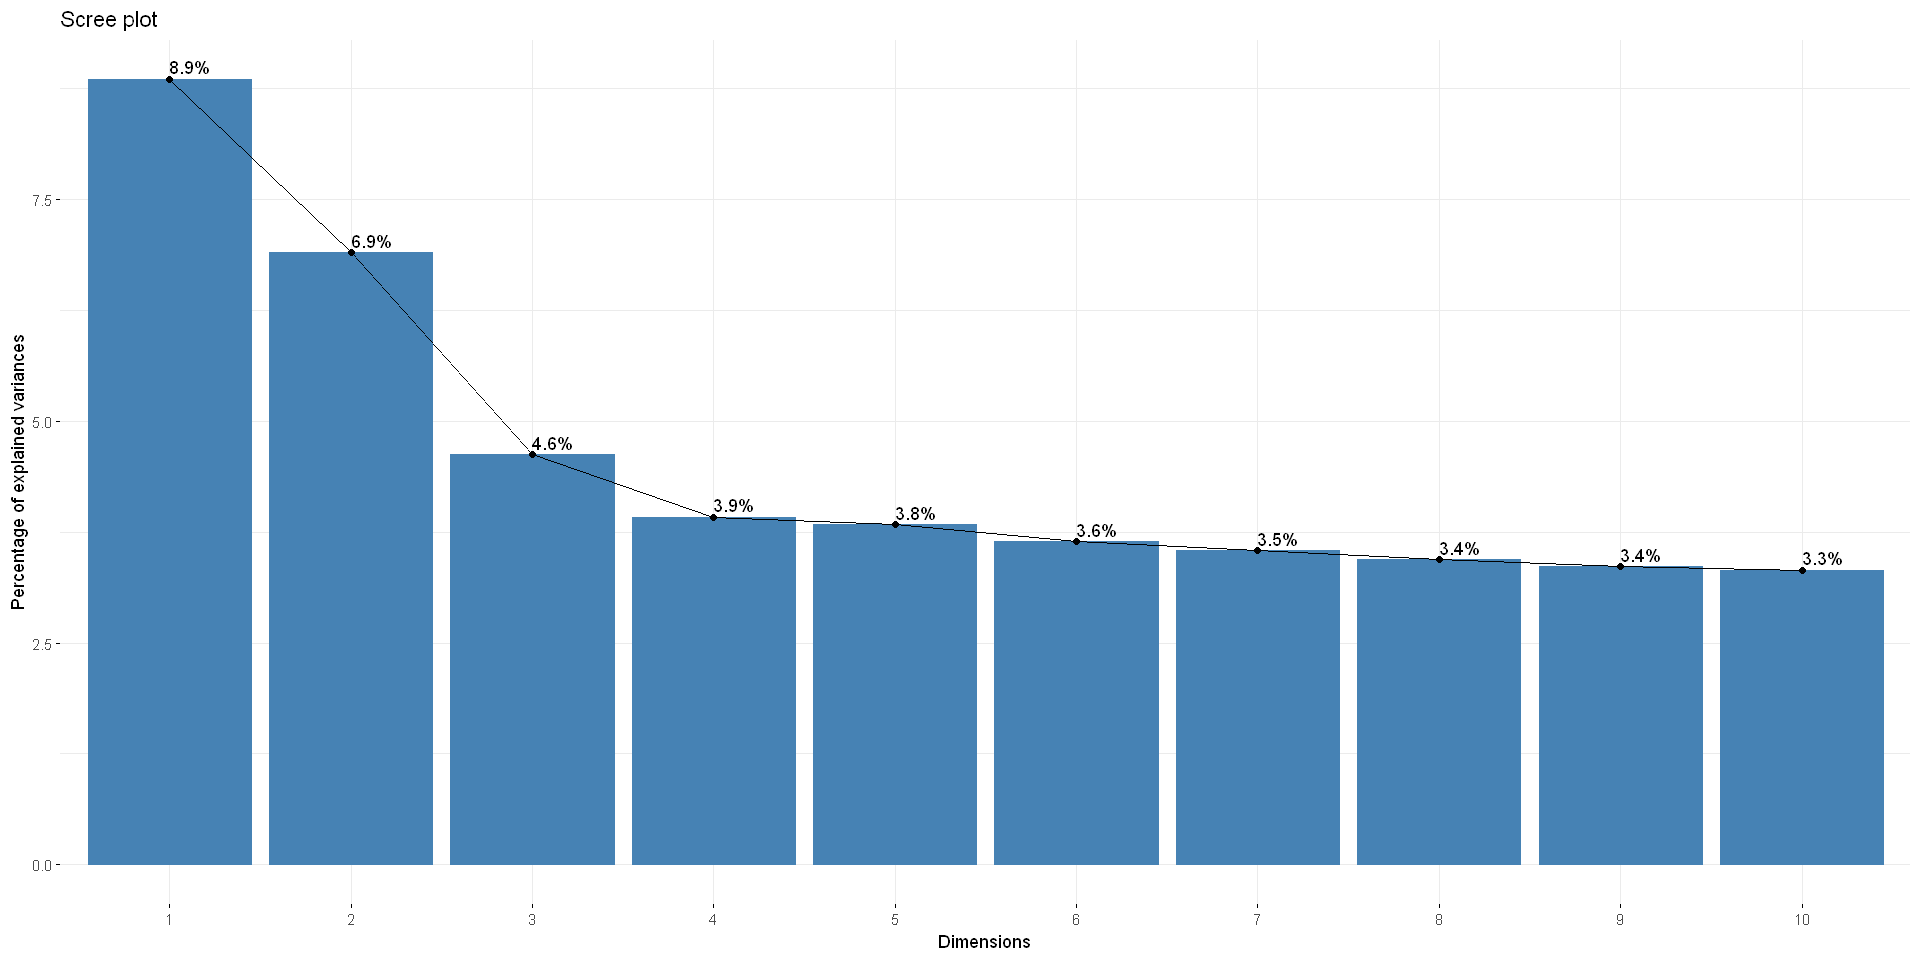

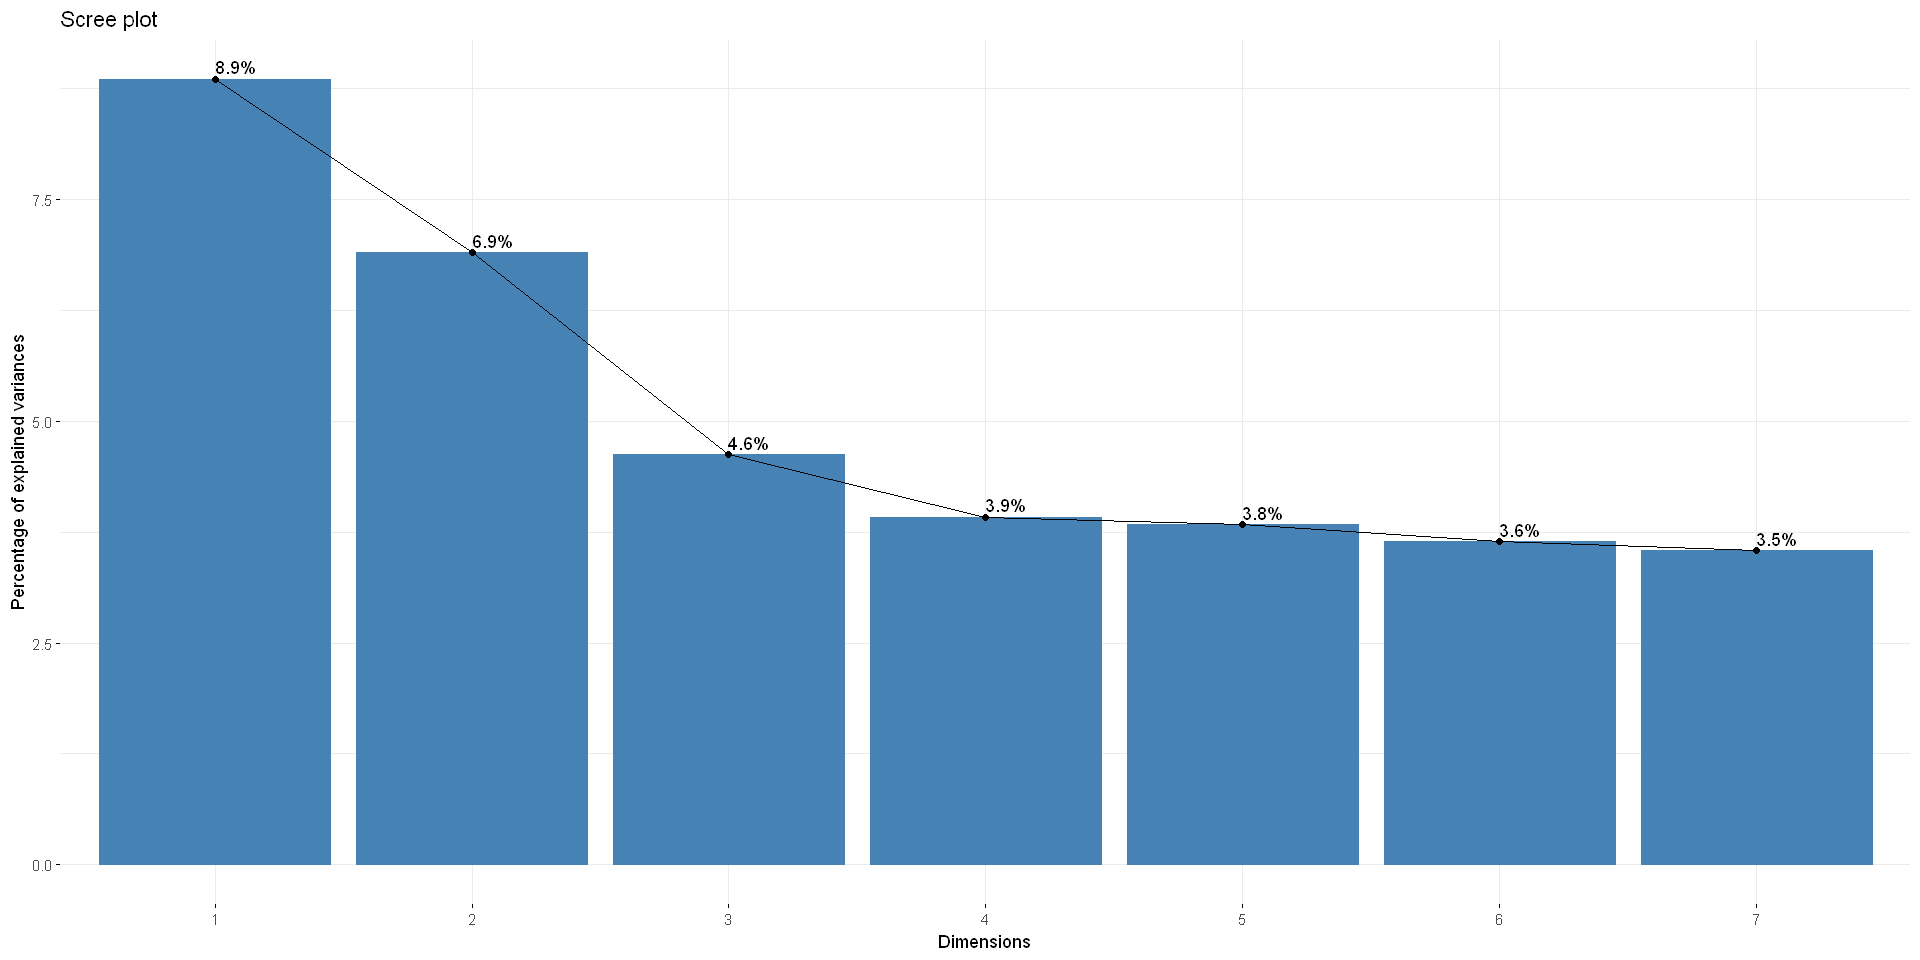

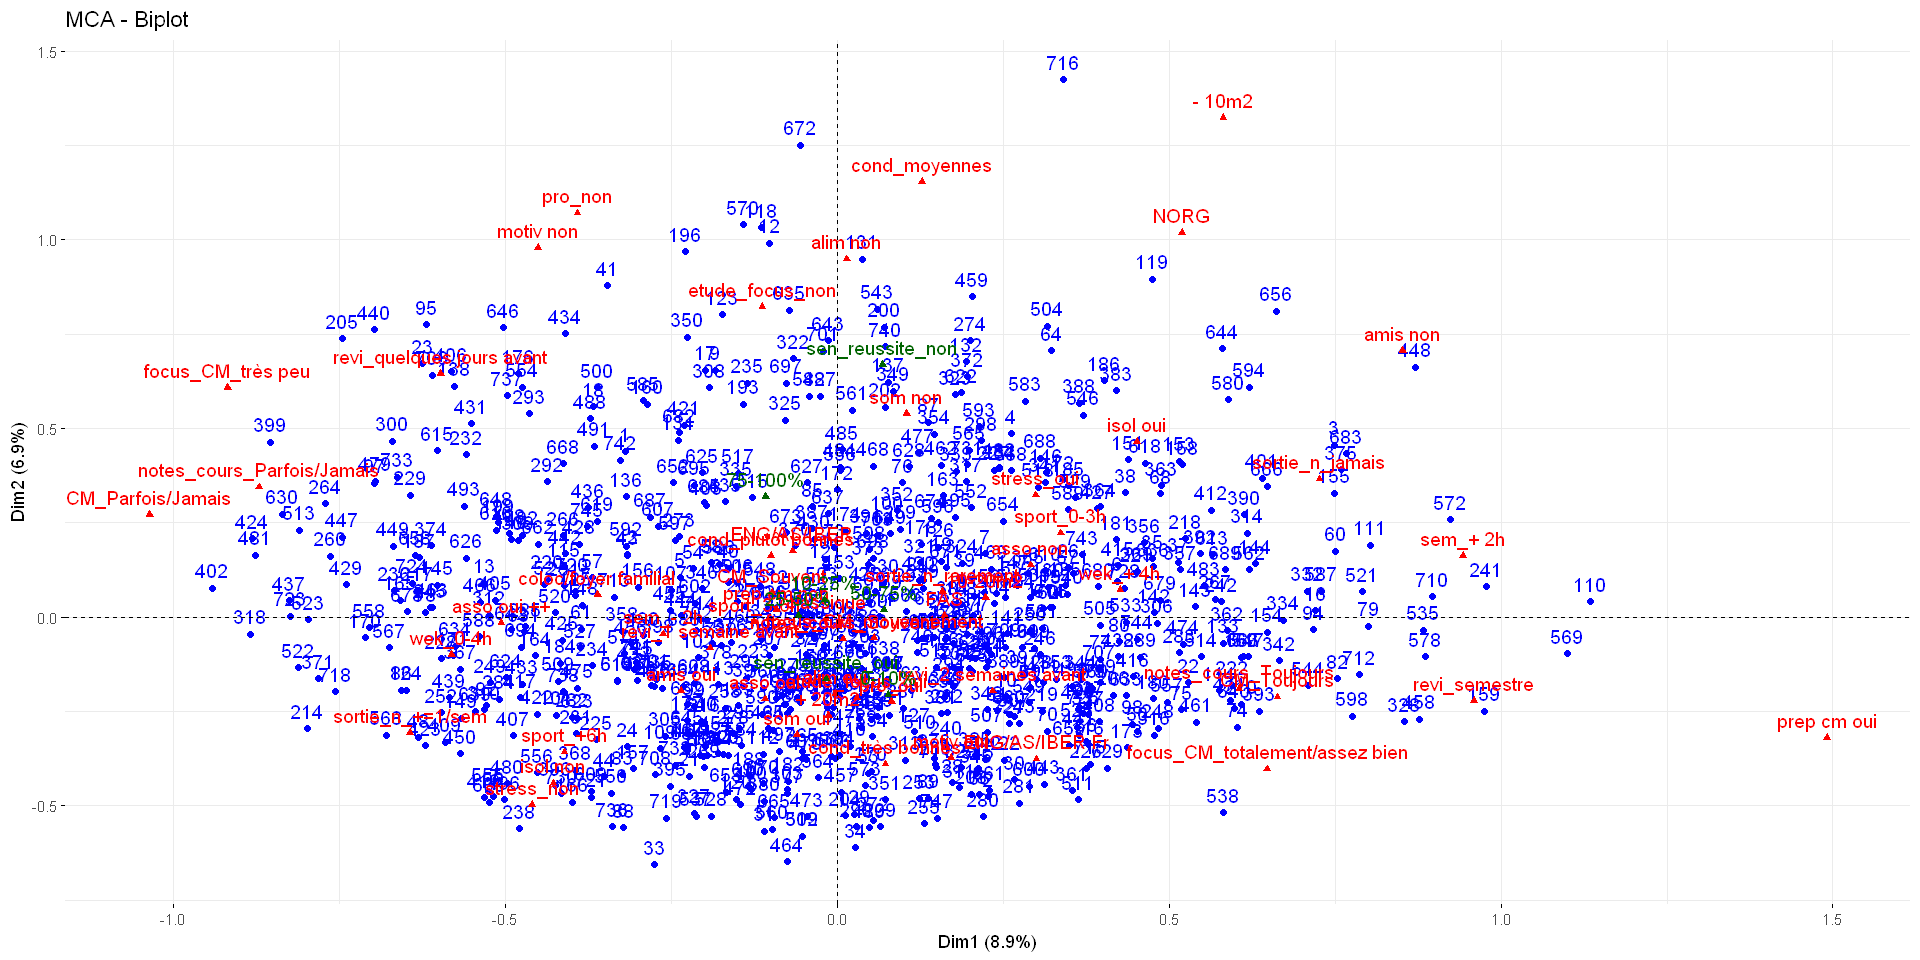

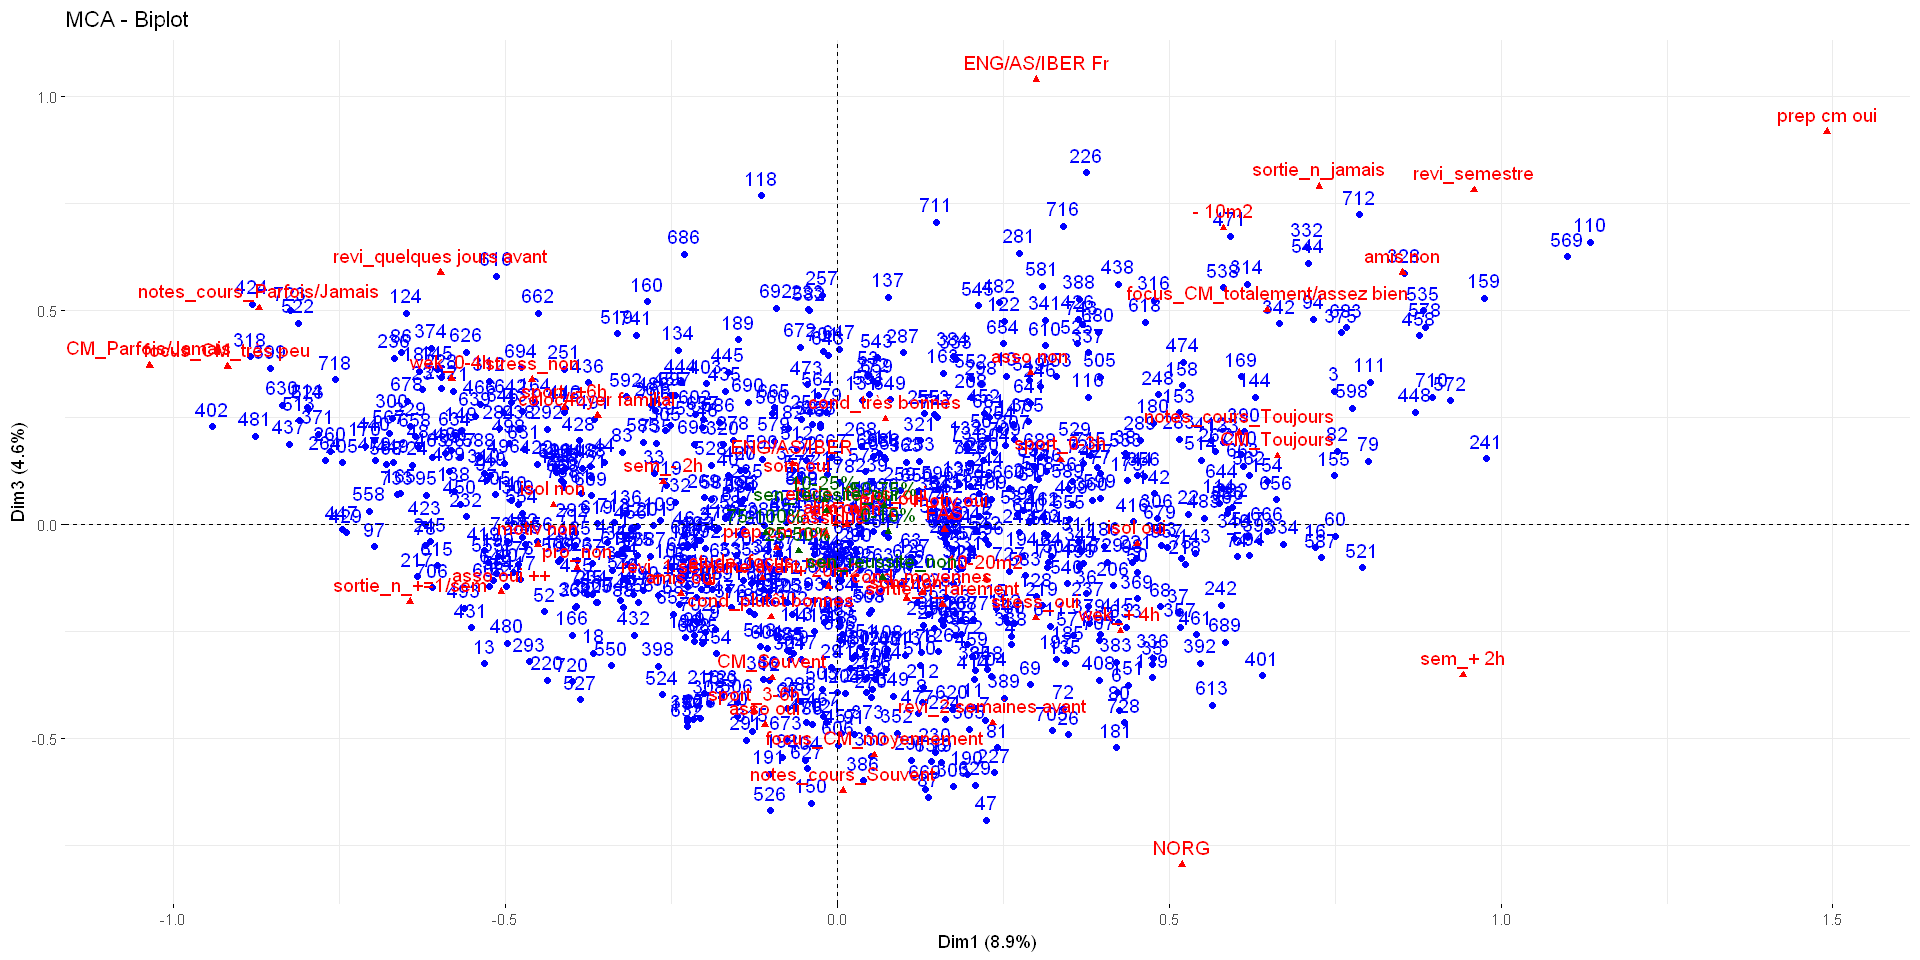

In [58]:
mca = MCA(insa1,quali.sup=c("Resultat_preced","Sensation_reussite"),graph=FALSE)
head(mca$eig)
fviz_screeplot(mca, addlabels=TRUE)
fviz_screeplot(mca, addlabels=TRUE, ncp=7)
fviz_mca_biplot(mca)
fviz_mca_biplot(mca, axes=c(1,3))

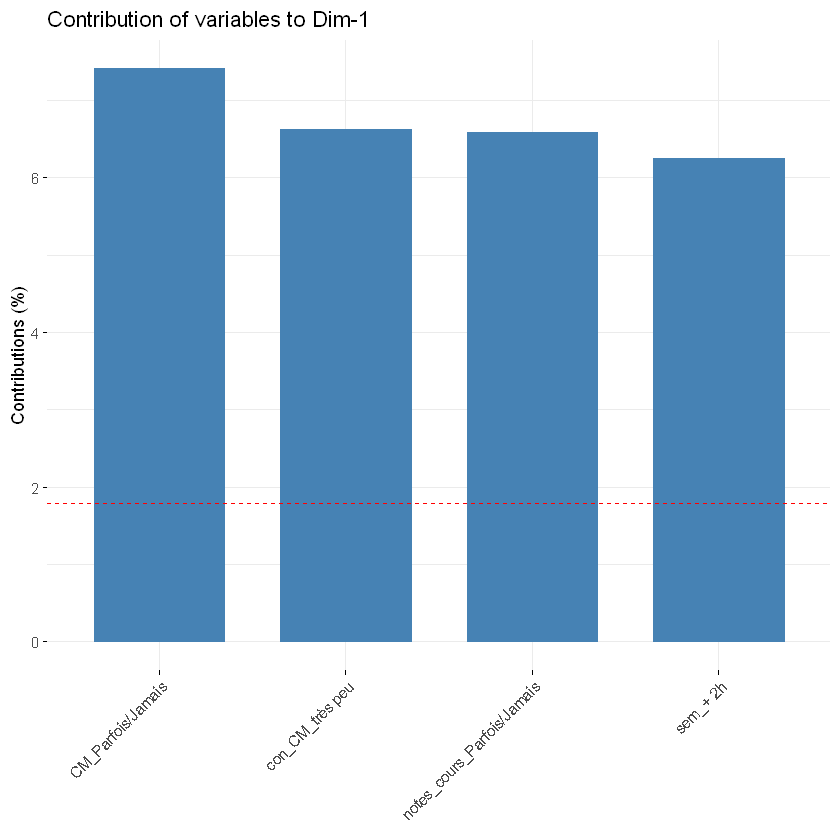

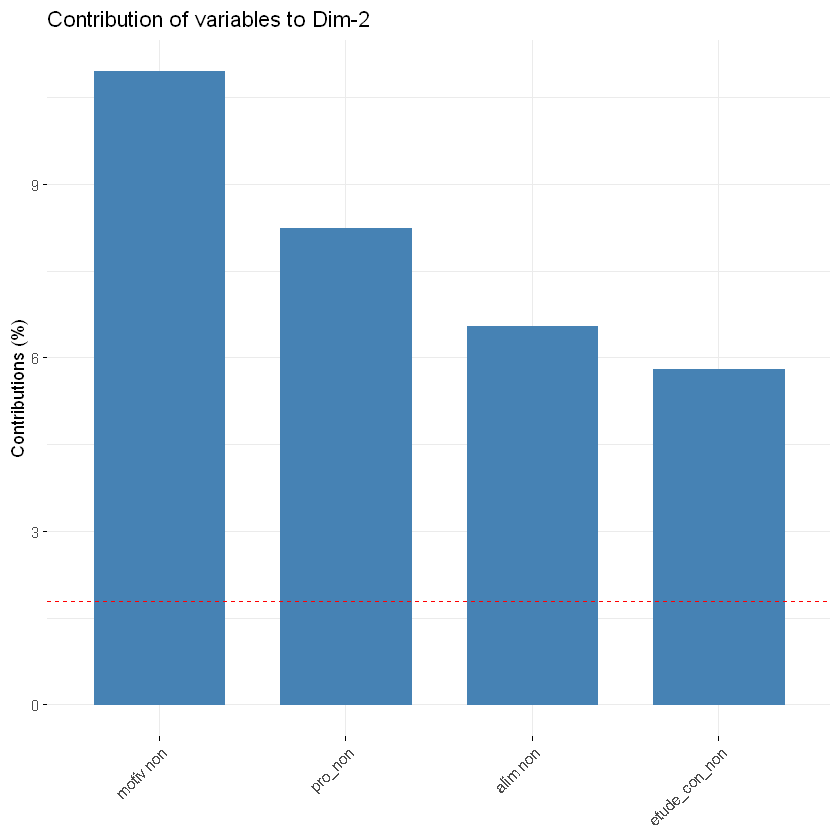

In [21]:
fviz_contrib(mca, choice="var", axes=1, top=4)

fviz_contrib(mca, choice="var", axes=2, top=4)

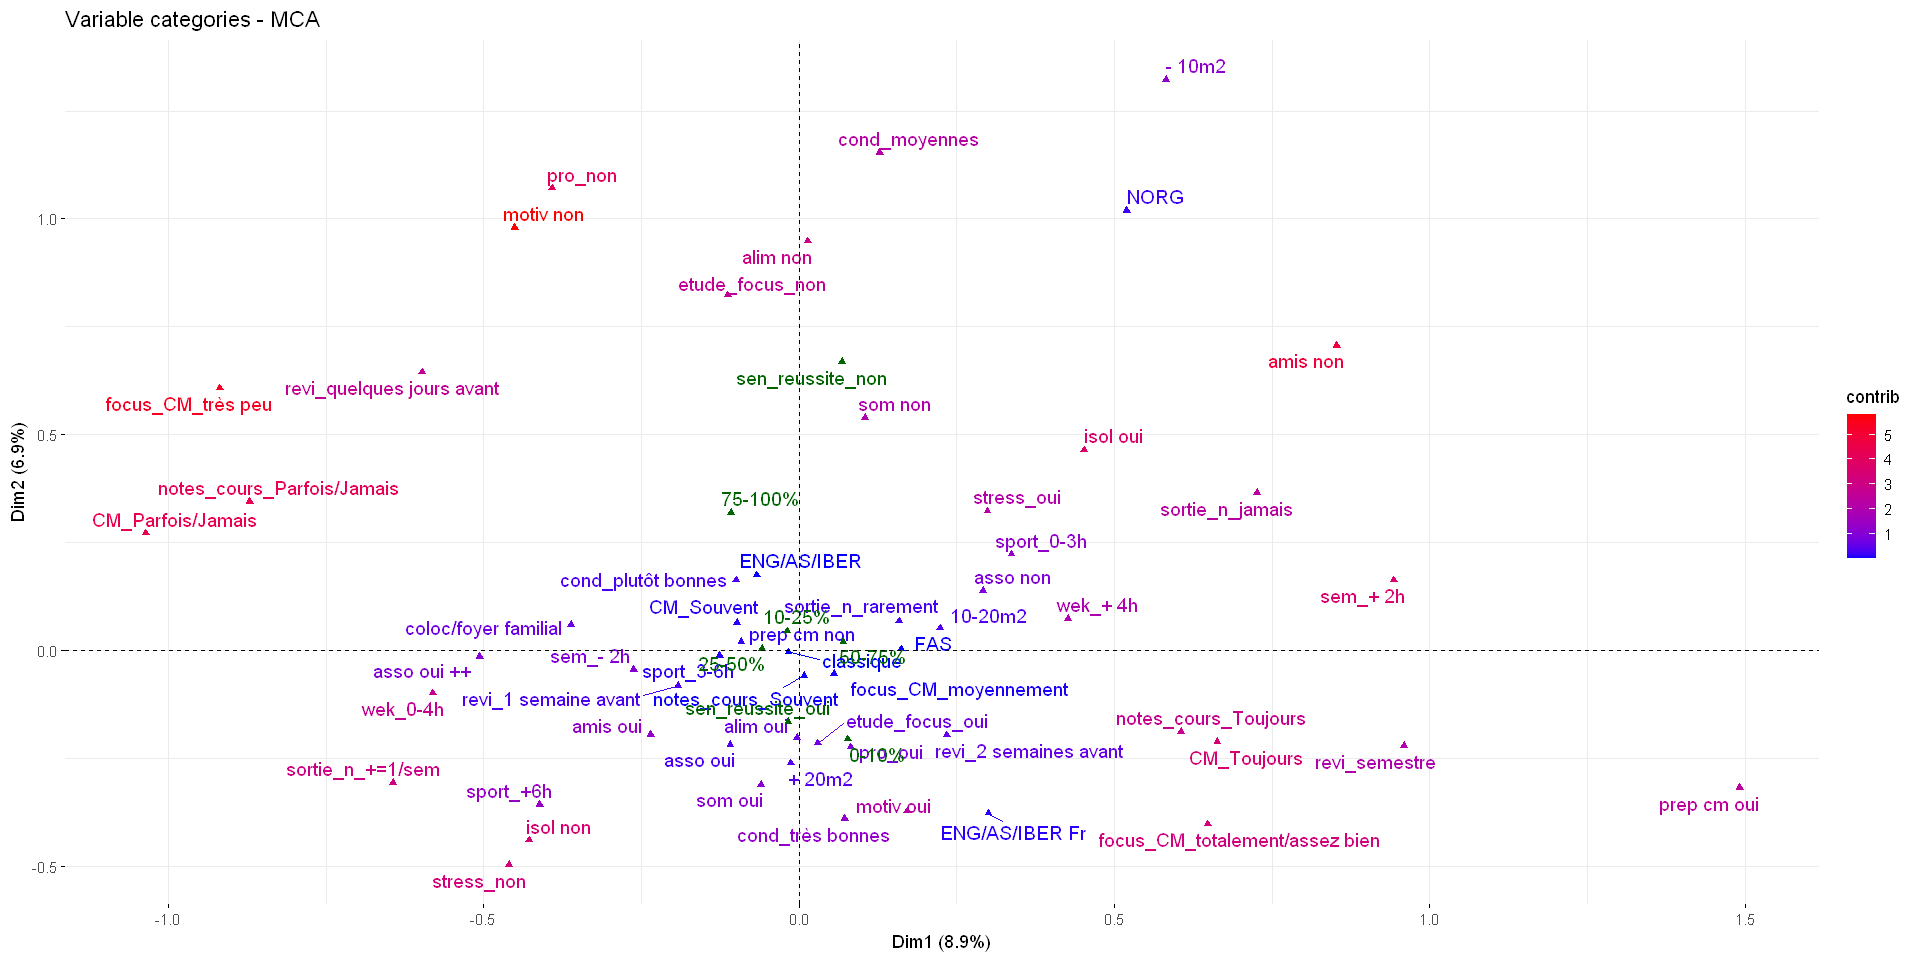

In [59]:
options(repr.plot.width = 16, repr.plot.height = 8)
fviz_mca_var(mca, col.var = "contrib",
             gradient.cols = c("blue", "red"), axes=c(1,2),
             repel = TRUE, labelsize = 4)

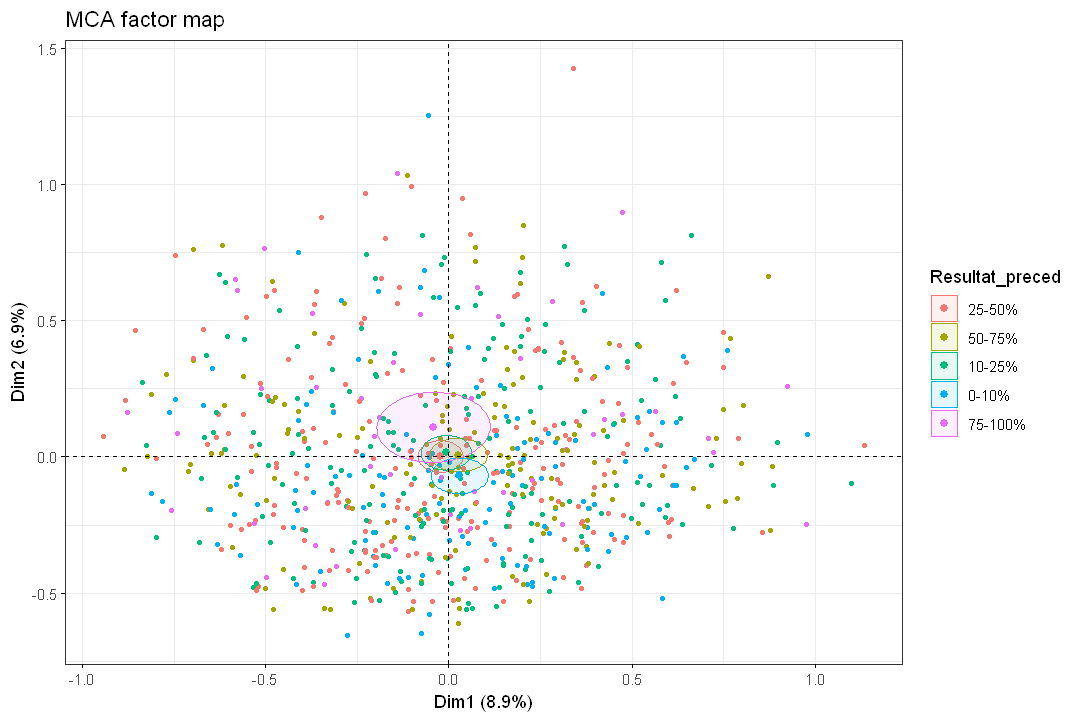

In [27]:
options(repr.plot.width = 9, repr.plot.height = 6)
fviz_ellipses(mca, c("Resultat_preced"),repel=FALSE,
              geom = "point")

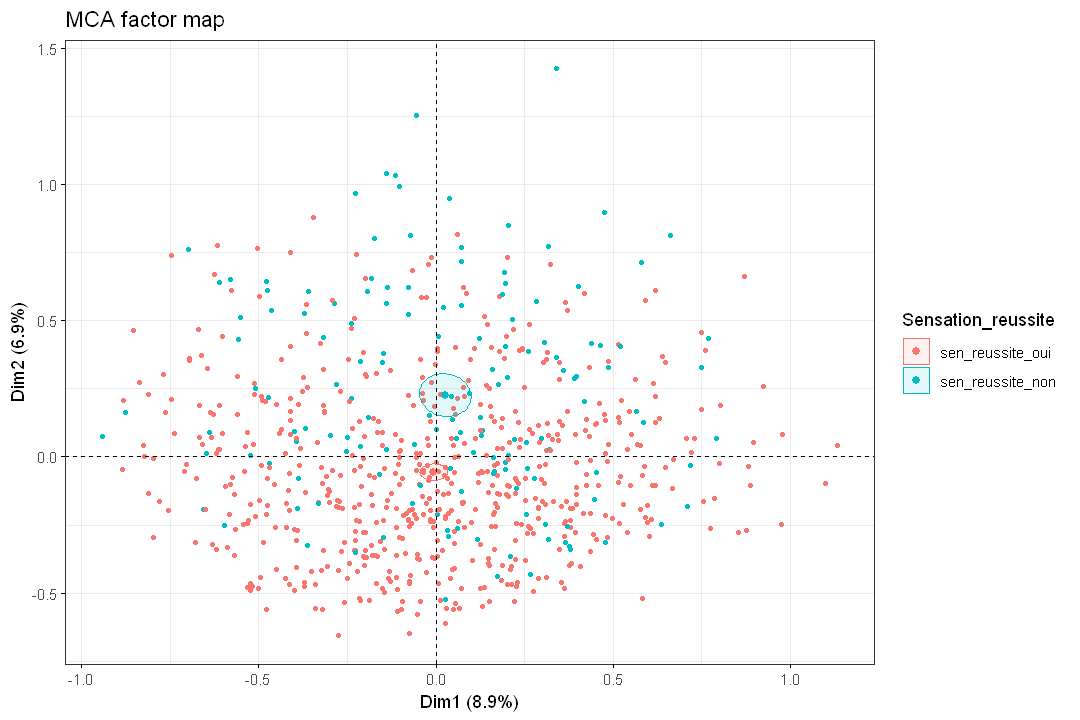

In [28]:
options(repr.plot.width = 9, repr.plot.height = 6)
fviz_ellipses(mca, c("Sensation_reussite"),repel=FALSE,
              geom = "point")

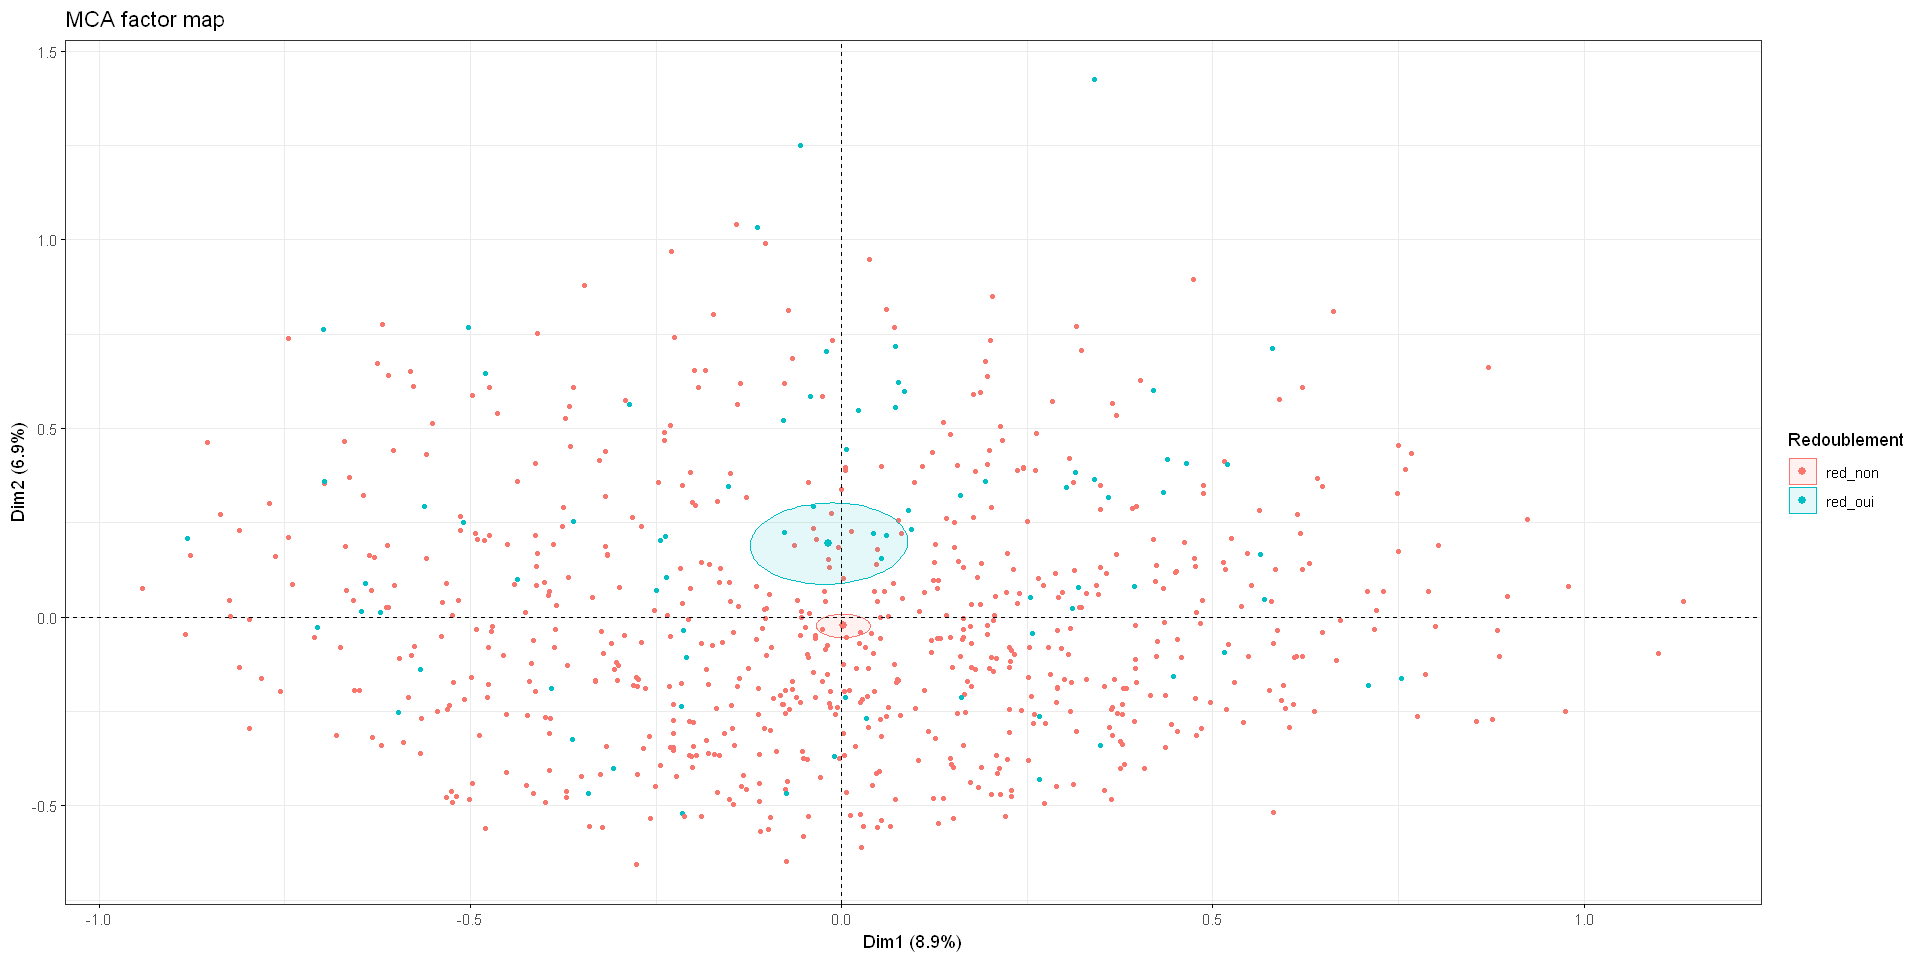

In [24]:
options(repr.plot.width = 16, repr.plot.height = 8)
fviz_ellipses(mca, c("Redoublement"),repel=FALSE,
              geom = "point")

In [12]:
library(nnet)

In [29]:
insa$Rattrapages = fct_collapse(insa$Rattrapages, "+2/sem" = c("jsp","+2/semestre"), "1/sem" = c("1/semestre"), "aucun" = c("aucun"))
insa$Rattrapges = factor(insa$Rattrapages, levels = c("aucun","1/sem","+2/sem"))

In [30]:
regm <- multinom(Rattrapages ~ act_pro + surf_logement + trajet + logement + sent_logement + Bourse + handicap + Tiers_Temps + Stress + travail_sem + travail_wek + Travail_groupe +
                 Travail_ext + Travail_dom + Presence_CM + Notes_cours + Prep_CM + Concentration_CM + revisions + efficacite + travail_cond + ressources_sup + Prep_TD_TP + Concentration_TD_TP +
                 Famille + Amis + isol + associatif + sport + Frequence_spectacle + sortie_nuit + detente + ecrans + sommeil + alimentation + Motivation + Adequation_projet_pro + Cohorte, data = insa)

# weights:  186 (122 variable)
initial  value 817.367543 
iter  10 value 588.484882
iter  20 value 570.673143
iter  30 value 569.584239
iter  40 value 569.254326
iter  50 value 568.985255
iter  60 value 568.856832
iter  70 value 568.810552
iter  80 value 568.786410
iter  90 value 568.784071
iter 100 value 568.783350
final  value 568.783350 
stopped after 100 iterations


In [31]:
regm2 <- step(regm)

Start:  AIC=1381.57
Rattrapages ~ act_pro + surf_logement + trajet + logement + sent_logement + 
    Bourse + handicap + Tiers_Temps + Stress + travail_sem + 
    travail_wek + Travail_groupe + Travail_ext + Travail_dom + 
    Presence_CM + Notes_cours + Prep_CM + Concentration_CM + 
    revisions + efficacite + travail_cond + ressources_sup + 
    Prep_TD_TP + Concentration_TD_TP + Famille + Amis + isol + 
    associatif + sport + Frequence_spectacle + sortie_nuit + 
    detente + ecrans + sommeil + alimentation + Motivation + 
    Adequation_projet_pro + Cohorte

trying - act_pro 
# weights:  183 (120 variable)
initial  value 817.367543 
iter  10 value 589.265505
iter  20 value 571.497602
iter  30 value 570.469447
iter  40 value 570.135704
iter  50 value 569.828461
iter  60 value 569.690265
iter  70 value 569.634969
iter  80 value 569.608067
iter  90 value 569.605001
iter 100 value 569.604284
final  value 569.604284 
stopped after 100 iterations
trying - surf_logement 
# weights:  17

In [32]:
summary(regm2)

Call:
multinom(formula = Rattrapages ~ sent_logement + Tiers_Temps + 
    Stress + Travail_ext + Presence_CM + Amis + isol + sport + 
    ecrans + Cohorte, data = insa)

Coefficients:
       (Intercept) sent_logementlog_plutôt oui sent_logementlog_plutôt non
1/sem    -2.470949                  0.03823081                 -0.09945839
+2/sem   -3.630433                  0.23189418                  1.56788625
       Tiers_TempsOui Stressstress_oui Travail_extext_oui Presence_CMCM_Souvent
1/sem       0.7381762        0.1974081          0.4853820             0.3123978
+2/sem      1.2192159        0.6646035          0.3475008             0.3077114
       Presence_CMCM_Parfois/Jamais Amisamis non isolisol oui sportsport_0-3h
1/sem                     0.8319320    0.2313195    0.5310289      -0.1677824
+2/sem                    0.6386266    0.6321371    0.2527799       0.2873133
       sportsport_+6h ecrans2-4h ecrans4-6h ecrans+6h CohorteFAS
1/sem       0.3547698  0.3508861 0.01193763 -0.17928

In [35]:
glm1 <- glm(Rattrapages ~ sent_logement + Tiers_Temps + 
    Stress + Travail_ext + Presence_CM + Amis + isol + sport + 
    ecrans, family = binomial, data=insa)
summary(glm1)


Call:
glm(formula = Rattrapages ~ sent_logement + Tiers_Temps + Stress + 
    Travail_ext + Presence_CM + Amis + isol + sport + ecrans, 
    family = binomial, data = insa)

Coefficients:
                              Estimate Std. Error z value Pr(>|z|)    
(Intercept)                  -2.116052   0.291998  -7.247 4.27e-13 ***
sent_logementlog_plutôt oui   0.122930   0.167043   0.736  0.46178    
sent_logementlog_plutôt non   0.983073   0.382686   2.569  0.01020 *  
Tiers_TempsOui                0.871370   0.310662   2.805  0.00503 ** 
Stressstress_oui              0.388399   0.177888   2.183  0.02901 *  
Travail_extext_oui            0.412573   0.169588   2.433  0.01498 *  
Presence_CMCM_Souvent         0.270605   0.186464   1.451  0.14671    
Presence_CMCM_Parfois/Jamais  0.721656   0.220852   3.268  0.00108 ** 
Amisamis non                  0.381353   0.204753   1.862  0.06253 .  
isolisol oui                  0.356664   0.178873   1.994  0.04616 *  
sportsport_0-3h               

In [36]:
regm <- multinom(Sensation_reussite ~ act_pro + surf_logement + trajet + logement + sent_logement + Bourse + handicap + Tiers_Temps + Stress + travail_sem + travail_wek + Travail_groupe +
                 Travail_ext + Travail_dom + Presence_CM + Notes_cours + Prep_CM + Concentration_CM + revisions + efficacite + travail_cond + ressources_sup + Prep_TD_TP + Concentration_TD_TP +
                 Famille + Amis + isol + associatif + sport + Frequence_spectacle + sortie_nuit + detente + ecrans + sommeil + alimentation + Motivation + Adequation_projet_pro + Cohorte, data = insa)

# weights:  62 (61 variable)
initial  value 515.701502 
iter  10 value 289.426828
iter  20 value 279.957107
iter  30 value 277.535303
iter  40 value 277.457209
iter  50 value 277.455419
final  value 277.455368 
converged


In [37]:
regm2 <- step(regm)

Start:  AIC=676.91
Sensation_reussite ~ act_pro + surf_logement + trajet + logement + 
    sent_logement + Bourse + handicap + Tiers_Temps + Stress + 
    travail_sem + travail_wek + Travail_groupe + Travail_ext + 
    Travail_dom + Presence_CM + Notes_cours + Prep_CM + Concentration_CM + 
    revisions + efficacite + travail_cond + ressources_sup + 
    Prep_TD_TP + Concentration_TD_TP + Famille + Amis + isol + 
    associatif + sport + Frequence_spectacle + sortie_nuit + 
    detente + ecrans + sommeil + alimentation + Motivation + 
    Adequation_projet_pro + Cohorte

trying - act_pro 
# weights:  61 (60 variable)
initial  value 515.701502 
iter  10 value 290.179289
iter  20 value 280.055073
iter  30 value 277.799435
iter  40 value 277.704476
iter  50 value 277.702375
final  value 277.702324 
converged
trying - surf_logement 
# weights:  59 (58 variable)
initial  value 515.701502 
iter  10 value 297.970391
iter  20 value 283.159915
iter  30 value 281.106584
iter  40 value 281.053389

In [38]:
summary(regm2)

Call:
multinom(formula = Sensation_reussite ~ surf_logement + trajet + 
    sent_logement + Tiers_Temps + Stress + Travail_groupe + Travail_ext + 
    Travail_dom + Presence_CM + Notes_cours + Prep_CM + efficacite + 
    Concentration_TD_TP + sport + sortie_nuit + alimentation + 
    Motivation, data = insa)

Coefficients:
                                              Values Std. Err.
(Intercept)                              -4.29528128 0.7664162
surf_logement+ 20m2                      -0.46542089 0.2850074
surf_logement- 10m2                       0.84589982 0.5243259
surf_logementcoloc/foyer familial        -0.13799300 0.3006475
trajet+ 10min                             0.85721796 0.2667095
sent_logementlog_plutôt oui               0.31065738 0.2370359
sent_logementlog_plutôt non               1.16410527 0.4432011
Tiers_TempsOui                            0.73667090 0.3644835
Stressstress_oui                          1.04779513 0.2613575
Travail_groupegroupe_oui                 -0.5

In [65]:
glm1 <- glm(Sensation_reussite ~ trajet + 
    sent_logement + Tiers_Temps + Stress + Travail_groupe + Travail_ext + Presence_CM + Notes_cours + efficacite + sport + sortie_nuit + alimentation + 
    Motivation, family = binomial, data=insa)
summary(glm1)


Call:
glm(formula = Sensation_reussite ~ trajet + sent_logement + Tiers_Temps + 
    Stress + Travail_groupe + Travail_ext + Presence_CM + Notes_cours + 
    efficacite + sport + sortie_nuit + alimentation + Motivation, 
    family = binomial, data = insa)

Coefficients:
                                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)                           -3.689902   0.419530  -8.795  < 2e-16 ***
trajet+ 10min                          0.655412   0.232089   2.824  0.00474 ** 
sent_logementlog_plutôt oui            0.382800   0.222504   1.720  0.08536 .  
sent_logementlog_plutôt non            1.290970   0.419002   3.081  0.00206 ** 
Tiers_TempsOui                         0.741798   0.352478   2.105  0.03533 *  
Stressstress_oui                       0.990330   0.251954   3.931 8.47e-05 ***
Travail_groupegroupe_oui              -0.507036   0.251455  -2.016  0.04376 *  
Travail_extext_oui                     0.727385   0.232496   3.129  0.00176 ** 
Presenc

In [68]:
table(insa$Sensation_reussite,insa$Notes_cours)

                  
                   notes_cours_Souvent notes_cours_Toujours
  sen_reussite_oui                 206                  225
  sen_reussite_non                  54                   59
                  
                   notes_cours_Parfois/Jamais
  sen_reussite_oui                        166
  sen_reussite_non                         34

# weights:  17 (16 variable)
initial  value 515.701502 
iter  10 value 309.946417
iter  20 value 307.042785
final  value 307.037631 
converged


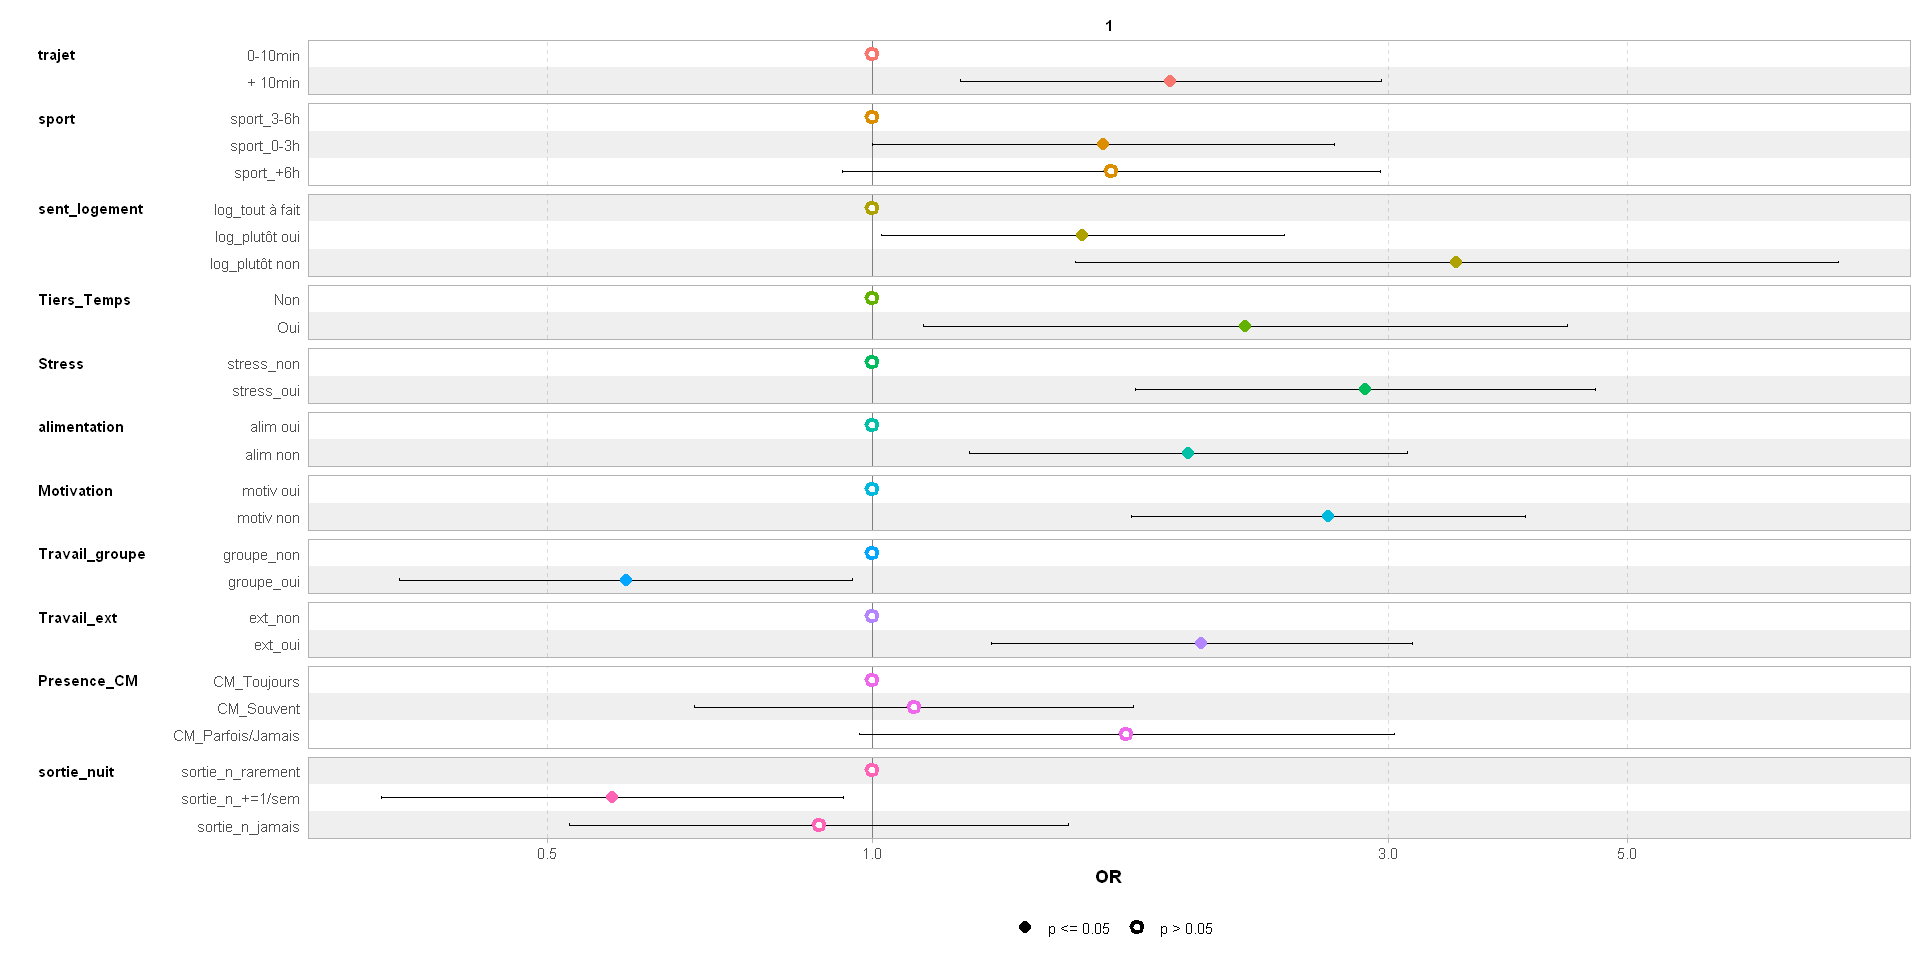

In [67]:
options(repr.plot.width = 16, repr.plot.height = 8)
library(GGally)
regm3 <- multinom(Sensation_reussite ~ trajet + sport +
    sent_logement + Tiers_Temps + Stress + alimentation + 
    Motivation+ Travail_groupe + Travail_ext + Presence_CM + sortie_nuit, data = insa)
ggcoef_multinom(regm3,type = "faceted",exponentiate = TRUE)

In [39]:
library(cvms)
library(ggimage)
library(rsvg)
library(knitr)
library(viridis)

Le chargement a nécessité le package : viridisLite



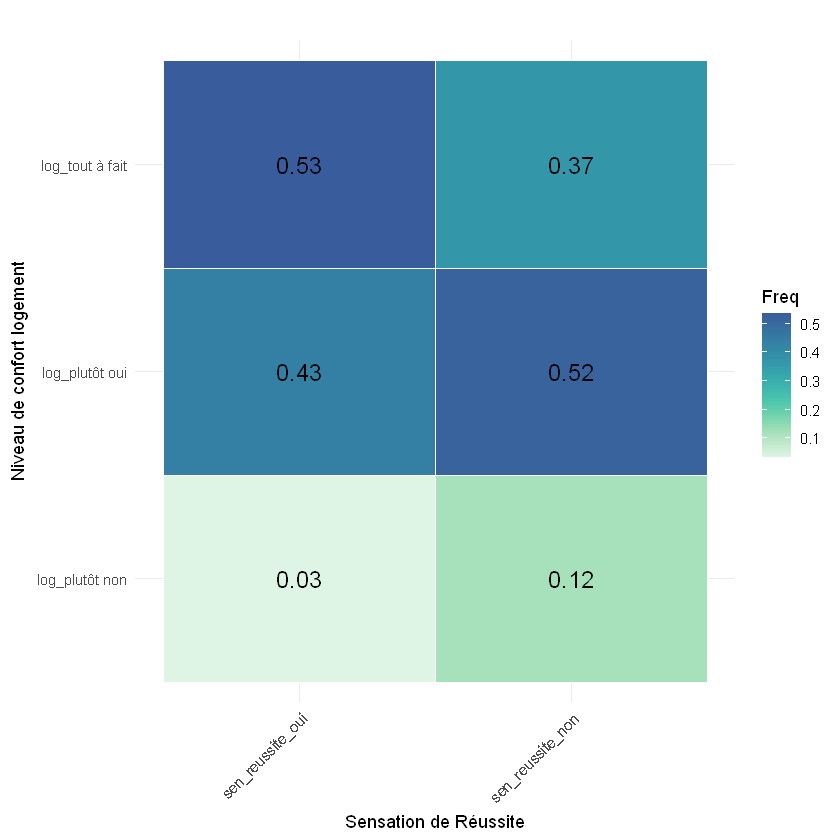

In [79]:
options(repr.plot.width = 7, repr.plot.height = 7)
conf_mat = table(insa$sent_logement,insa$Sensation_reussite)
profils_colonnes <- prop.table(conf_mat, margin = 2)
df_profils <- as.data.frame(as.table(profils_colonnes))
colnames(df_profils) <- c("sent_logement", "Sensation_Reussite", "Freq")
ggplot(data = df_profils, aes(x = Sensation_Reussite, y = , fill = Freq)) +
  scale_y_discrete(limits = rev(levels(df_profils$sent_logement))) +
  geom_tile(color = "white") +
  scale_fill_viridis(option = "G", direction = -1, begin = 0.4, end = 1) +
  geom_text(aes(label = sprintf("%.2f", Freq)), color = "black", size = 5) +
  labs(title = "", x = "Sensation de Réussite", y = "Niveau de confort logement") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

Le chargement a nécessité le package : viridisLite



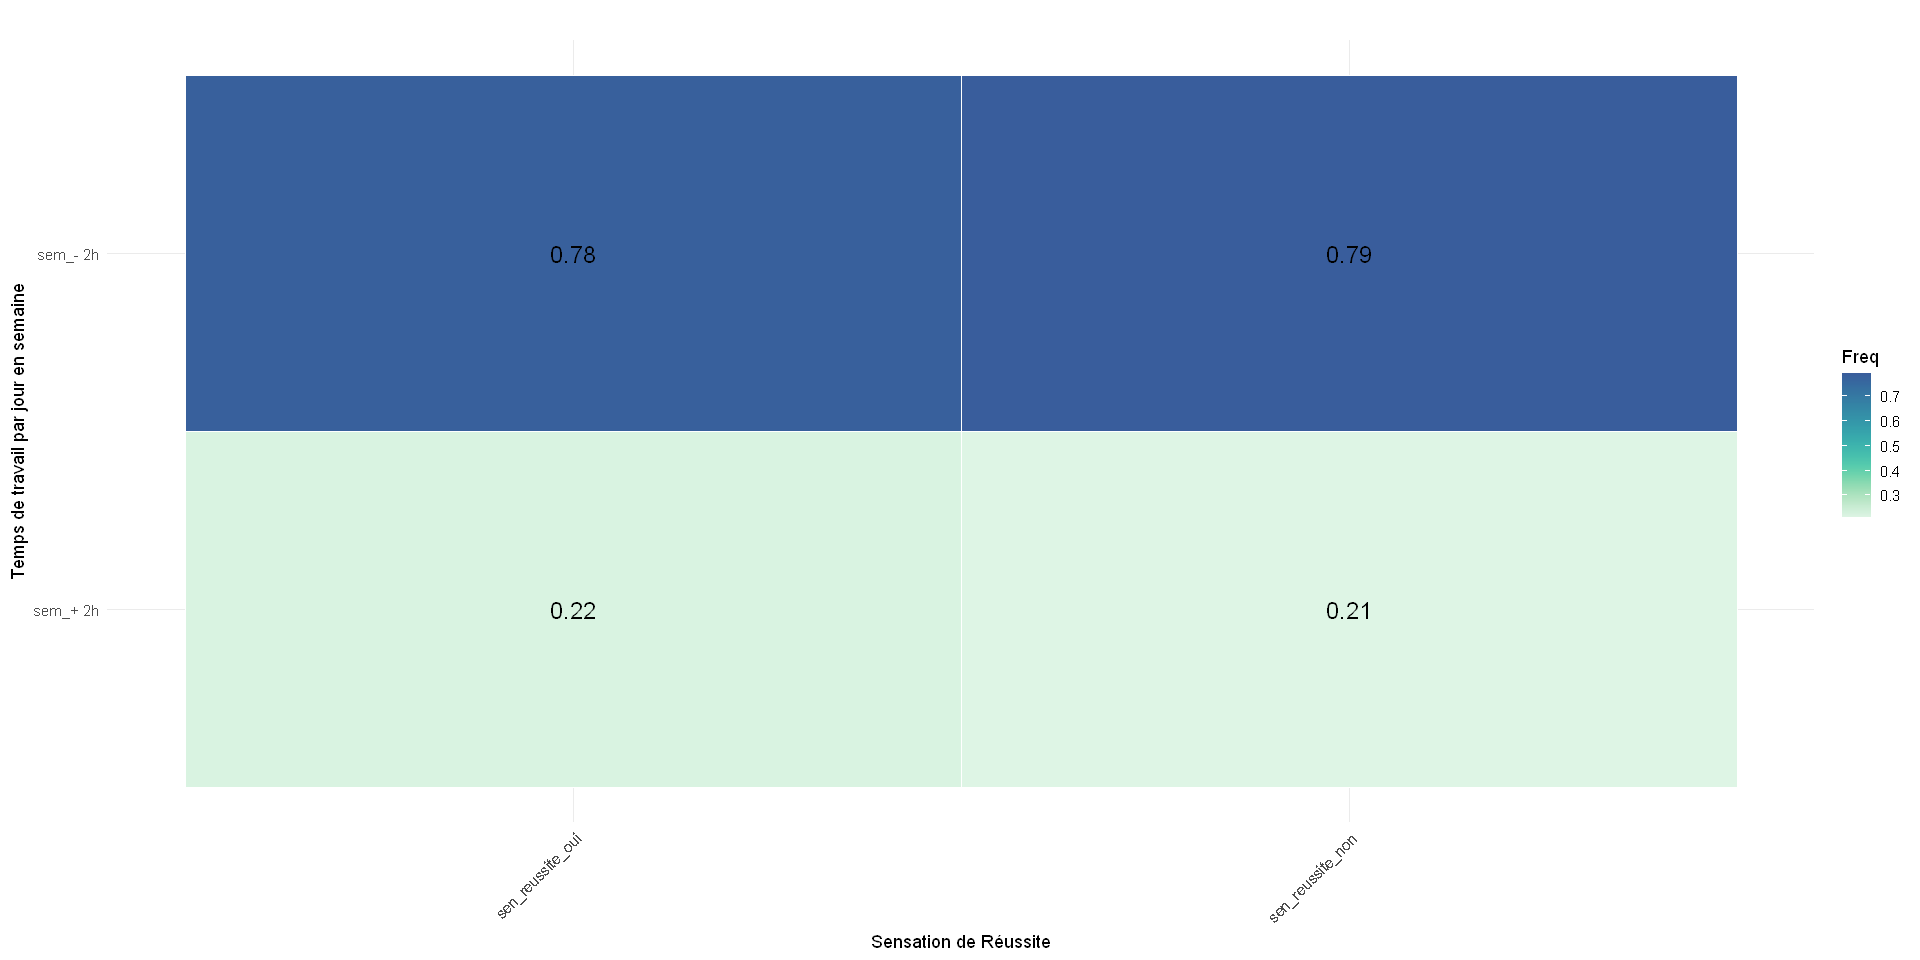

In [70]:
options(repr.plot.width = 7, repr.plot.height = 7)
library(viridis)
conf_mat = table(insa$travail_sem,insa$Sensation_reussite)
profils_colonnes <- prop.table(conf_mat, margin = 2)
df_profils <- as.data.frame(as.table(profils_colonnes))
colnames(df_profils) <- c("travail_sem", "Sensation_Reussite", "Freq")
ggplot(data = df_profils, aes(x = Sensation_Reussite, y = travail_sem, fill = Freq)) +
  scale_y_discrete(limits = rev(levels(df_profils$travail_sem))) +
  geom_tile(color = "white") +
  scale_fill_viridis(option = "G", direction = -1, begin = 0.4, end = 1) +
  geom_text(aes(label = sprintf("%.2f", Freq)), color = "black", size = 5) +
  labs(title = "", x = "Sensation de Réussite", y = "Temps de travail par jour en semaine") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

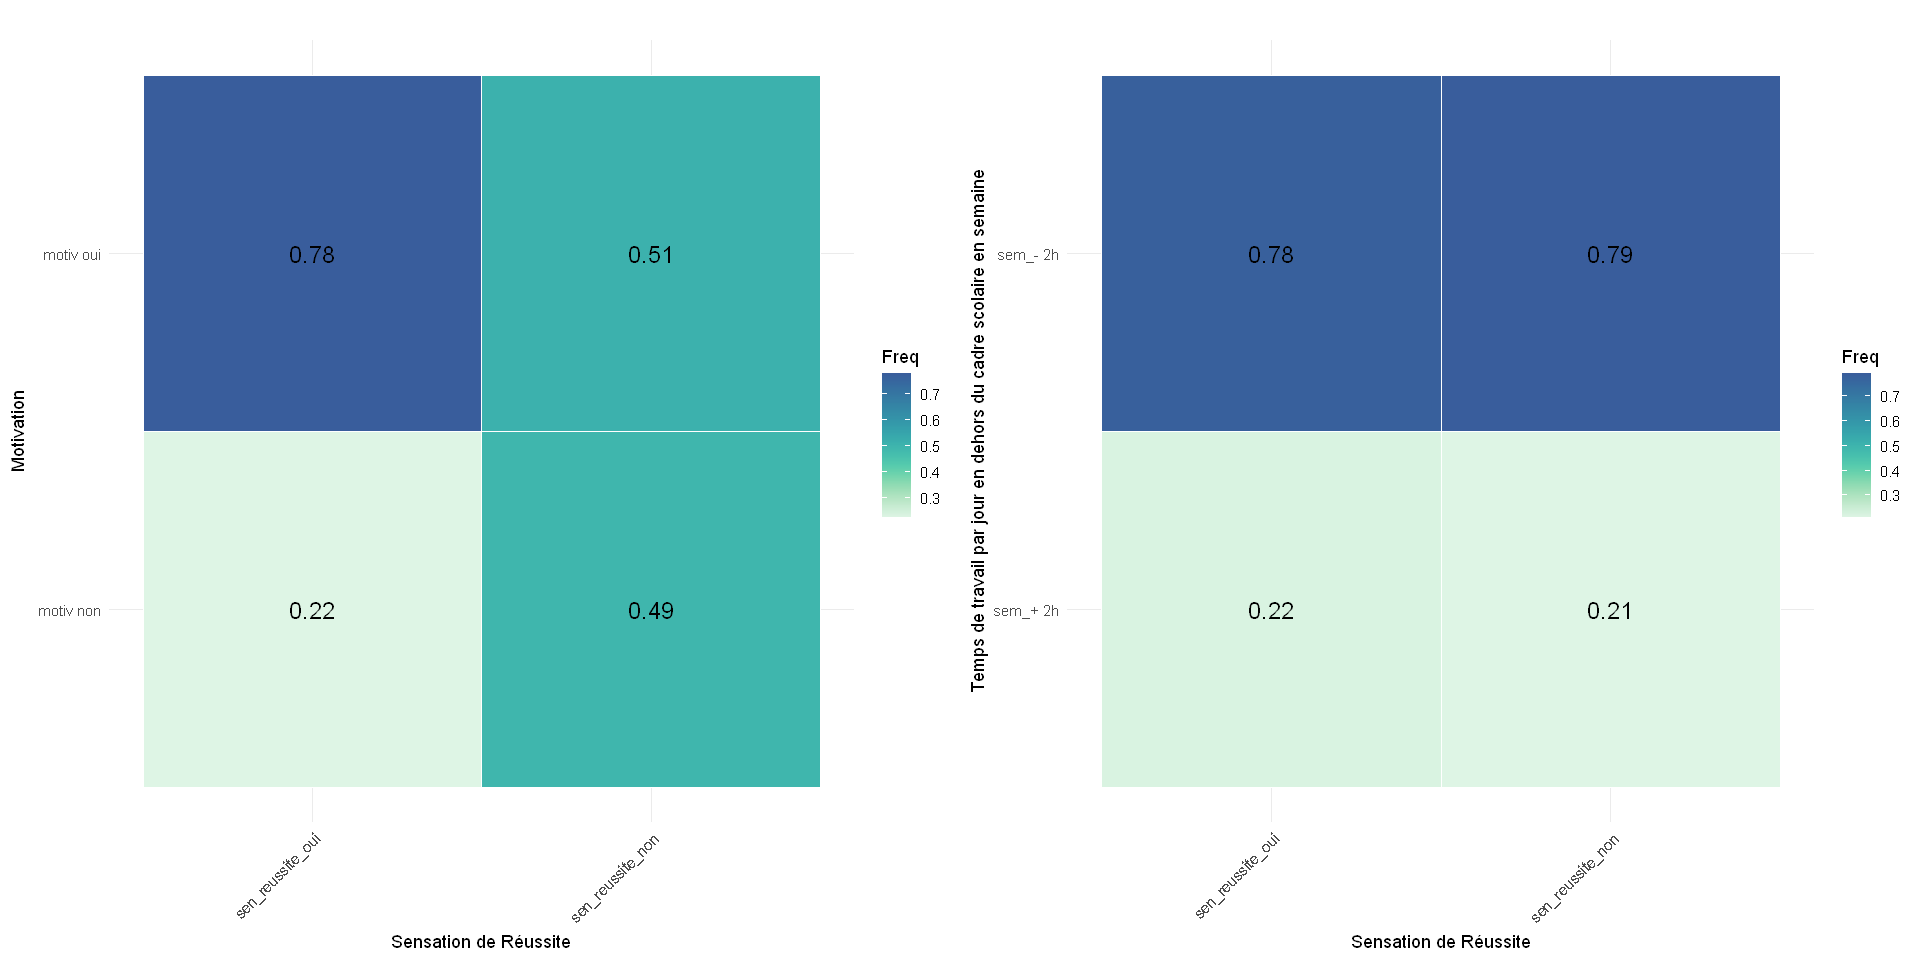

In [91]:
options(repr.plot.width = 16, repr.plot.height = 8)
conf_mat = table(insa$travail_sem,insa$Sensation_reussite)
profils_colonnes <- prop.table(conf_mat, margin = 2)
df_profils <- as.data.frame(as.table(profils_colonnes))
colnames(df_profils) <- c("travail_sem", "Sensation_Reussite", "Freq")
plot2 = ggplot(data = df_profils, aes(x = Sensation_Reussite, y = travail_sem, fill = Freq)) +
  scale_y_discrete(limits = rev(levels(df_profils$travail_sem))) +
  geom_tile(color = "white") +
  scale_fill_viridis(option = "G", direction = -1, begin = 0.4, end = 1) +
  geom_text(aes(label = sprintf("%.2f", Freq)), color = "black", size = 5) +
  labs(title = "", x = "Sensation de Réussite", y = "Temps de travail par jour en dehors du cadre scolaire en semaine") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))
conf_mat = table(insa$Motivation,insa$Sensation_reussite)
profils_colonnes <- prop.table(conf_mat, margin = 2)
df_profils <- as.data.frame(as.table(profils_colonnes))
colnames(df_profils) <- c("Motivation", "Sensation_Reussite", "Freq")
plot1 = ggplot(data = df_profils, aes(x = Sensation_Reussite, y = Motivation, fill = Freq)) +
  scale_y_discrete(limits = rev(levels(df_profils$Motivation))) +
  geom_tile(color = "white") +
  scale_fill_viridis(option = "G", direction = -1, begin = 0.4, end = 1) +
  geom_text(aes(label = sprintf("%.2f", Freq)), color = "black", size = 5) +
  labs(title = "", x = "Sensation de Réussite", y = "Motivation") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))
grid.arrange(plot1, plot2, ncol = 2)